In [1]:
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
from facenet_pytorch import MTCNN

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mtcnn = MTCNN(keep_all=True, device=device)

In [ ]:
# Load a pretrained ResNet-50
resnet = models.resnet50(weights='IMAGENET1K_V1')
resnet.eval()

import timm
vit = timm.create_model('vit_base_patch16_224', pretrained=True)
vit.eval()

### First image

In [ ]:
image = Image.open('hasnan_2.jpg')

# Detect faces
boxes, _ = mtcnn.detect(image)

# Draw bounding boxes and extract faces
fig, ax = plt.subplots()
ax.imshow(image)
for box in boxes:
    rect = plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], fill=False, color='red')
    ax.add_patch(rect)

    # Crop face
    face = image.crop(box)
    plt.imshow(face)
    plt.show()

In [32]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# face_tensor = transform(face).unsqueeze(0)

In [8]:
with torch.no_grad():
    resnet_features = resnet(face_tensor)
    vit_features = vit(face_tensor)

### Second image 

In [9]:
# Load the comparison image
image2 = Image.open('rama.jpg')

# Detect face in the second image
boxes2, _ = mtcnn.detect(image2)

# Assume we take the first detected face
face2 = image2.crop(boxes2[0])

# Transform the face image
face2_tensor = transform(face2).unsqueeze(0)  # Add batch dimension


In [10]:
with torch.no_grad():
    resnet_features2 = resnet(face2_tensor)
    vit_features2 = vit(face2_tensor)

In [11]:
from scipy.spatial.distance import cosine

# Calculate cosine similarity between ResNet features
similarity_resnet = 1 - cosine(resnet_features.flatten(), resnet_features2.flatten())

# Calculate cosine similarity between ViT features
similarity_vit = 1 - cosine(vit_features.flatten(), vit_features2.flatten())

print(f"Cosine similarity using ResNet: {similarity_resnet}")
print(f"Cosine similarity using ViT: {similarity_vit}")

Cosine similarity using ResNet: 0.7534234628960255
Cosine similarity using ViT: 0.7828350609417452


In [13]:
threshold = 0.7  # This threshold should be fine-tuned based on your specific dataset and requirements

if similarity_resnet > threshold:
    print("Faces matched using ResNet features.")
else:
    print("Faces did not match using ResNet features.")

if similarity_vit > threshold:
    print("Faces matched using ViT features.")
else:
    print("Faces did not match using ViT features.")

Faces matched using ResNet features.
Faces matched using ViT features.


## coba coba

In [2]:
from facenet_pytorch import MTCNN, InceptionResnetV1
import torch
from PIL import Image

# Initialize MTCNN for face detection
mtcnn = MTCNN(keep_all=True)

# Load pre-trained FaceNet model
resnet = InceptionResnetV1(pretrained='casia-webface').eval()

# Load an image containing faces
img = Image.open('images_asset\messi_1.jpeg')

In [3]:
# Detect faces in the image
boxes, _ = mtcnn.detect(img)

# If faces are detected, extract embeddings
if boxes is not None:
    aligned = mtcnn(img)
    embeddings = resnet(aligned).detach()

In [5]:
embeddings.shape

torch.Size([1, 512])

In [6]:
img_2 = Image.open('images_asset\messi_2.jpeg')
# Detect faces in the image
boxes_2, _ = mtcnn.detect(img_2)

# If faces are detected, extract embeddings
if boxes_2 is not None:
    aligned_2 = mtcnn(img_2)
    embeddings_2 = resnet(aligned_2).detach()

In [10]:
from scipy.spatial.distance import cosine

# Calculate cosine similarity between ResNet features
similarity_resnet = 1 - cosine(embeddings.flatten(), embeddings_2.flatten())

print(f"Cosine similarity using ResNet: {similarity_resnet}")

Cosine similarity using ResNet: 0.3450692296028137


In [26]:
import torch
from PIL import Image
from facenet_pytorch import MTCNN, InceptionResnetV1
from torchvision import transforms

# Initialize MTCNN and InceptionResnetV1
mtcnn = MTCNN(keep_all=True)
resnet = InceptionResnetV1(pretrained='vggface2').eval()

# Function to load an image, detect and extract the primary face
def get_face_embedding(image_path):
    img = Image.open(image_path)
    # Detect faces
    faces = mtcnn(img)
    # Extract the primary face only (the largest one by MTCNN default)
    if faces is not None and len(faces) > 0:
        # Compute embedding with InceptionResnet
        with torch.no_grad():
            embedding = resnet(faces[0].unsqueeze(0)).squeeze(0)
        return embedding
    else:
        return None

# Load two images
img_path1 = 'images_asset/messi_1.jpeg'
img_path2 = 'images_asset/messi_3.jpeg'

# Get embeddings
embedding1 = get_face_embedding(img_path1)
embedding2 = get_face_embedding(img_path2)

# if embedding1 is not None and embedding2 is not None:
#     # Calculate cosine similarity
#     similarity = (embedding1 @ embedding2) / (embedding1.norm() * embedding2.norm())
#     print(f"Cosine similarity: {similarity.item():.4f}")
#     if similarity.item() > 0.8:  # Assuming threshold of 0.8
#         print("Images are of the same person.")
#     else:
#         print("Images are not of the same person.")
# else:
#     print("Could not detect faces in one or both images.")

In [20]:
import torch

def cosine_similarity(embedding1, embedding2):
    """
    Compute the cosine similarity between two embeddings.

    Args:
    embedding1 (torch.Tensor): A tensor representing the first embedding.
    embedding2 (torch.Tensor): A tensor representing the second embedding.

    Returns:
    float: The cosine similarity between the two embeddings.
    """
    # Ensure embeddings are floats for precision during division
    embedding1 = embedding1.float()
    embedding2 = embedding2.float()
    
    # Calculate the dot product of the embeddings
    dot_product = torch.dot(embedding1, embedding2)
    # Calculate the norm of each embedding
    norm1 = torch.norm(embedding1)
    norm2 = torch.norm(embedding2)
    # Compute cosine similarity
    similarity = dot_product / (norm1 * norm2)
    
    return similarity.item()


In [16]:
similarity_score = cosine_similarity(embedding1, embedding2)
print(f"Cosine Similarity: {similarity_score:.3f}")

Cosine Similarity: 0.693


## Training using triplet loss

In [1]:
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
from facenet_pytorch import MTCNN
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
import os
import random
import numpy as np
from torch.utils.data import Dataset, DataLoader

from PIL import Image

class TripletFaceDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.faces = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
        self.face_to_indices = {face: np.where(np.array(self.faces) == face)[0][0] for face in self.faces}

    def __getitem__(self, index):
        while True:
            face_id = self.faces[index]
            face_dir = os.path.join(self.root_dir, face_id)
            face_images = [os.path.join(face_dir, img) for img in os.listdir(face_dir) if img.endswith(('.png', '.jpg', '.jpeg'))]

            if len(face_images) >= 2:
                break
            else:
                # If the selected directory doesn't have enough images, pick another index
                index = random.randint(0, len(self.faces) - 1)
        
        anchor_idx, positive_idx = random.sample(range(len(face_images)), 2)
        anchor_img_path = face_images[anchor_idx]
        positive_img_path = face_images[positive_idx]

        # Select a valid negative sample
        while True:
            negative_face_id = random.choice([f for f in self.faces if f != face_id])
            negative_face_dir = os.path.join(self.root_dir, negative_face_id)
            negative_images = [os.path.join(negative_face_dir, img) for img in os.listdir(negative_face_dir) if img.endswith(('.png', '.jpg', '.jpeg'))]

            if negative_images:
                break

        negative_img_path = random.choice(negative_images)

        anchor_img = Image.open(anchor_img_path).convert("RGB")
        positive_img = Image.open(positive_img_path).convert("RGB")
        negative_img = Image.open(negative_img_path).convert("RGB")

        if self.transform:
            anchor_img = self.transform(anchor_img)
            positive_img = self.transform(positive_img)
            negative_img = self.transform(negative_img)

        return anchor_img, positive_img, negative_img

    def __len__(self):
        return len(self.faces)

In [20]:
transformations = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [6]:
# Set the directory path to your LFW dataset
datatrain_path = 'lfw-deepfunneled'
triplet_dataset = TripletFaceDataset(root_dir=datatrain_path, transform=transformations)

# Initialize DataLoader
triplet_loadertrain = DataLoader(triplet_dataset, batch_size=32, shuffle=True)


In [7]:
# Set the directory path to your LFW dataset
datatest_path = 'Datatest_face'
triplet_dataset_test = TripletFaceDataset(root_dir=datatest_path, transform=transformations)

# Initialize DataLoader
triplet_loadertest = DataLoader(triplet_dataset_test, batch_size=32, shuffle=True)

In [8]:
from facenet_pytorch import MTCNN, InceptionResnetV1
import torch
model_face = InceptionResnetV1(pretrained='vggface2').to(device)
mtcnn = MTCNN(keep_all=True, min_face_size=20, thresholds=[0.6, 0.7, 0.7])

In [9]:
from torch.optim import Adam
from torch.nn import TripletMarginLoss

optimizer = Adam(model_face.parameters(), lr=0.0001)
loss_func = TripletMarginLoss(margin=1.0)

def train(model, data_loader, loss_func, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for i, (anchor, positive, negative) in enumerate(data_loader):
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
            
            optimizer.zero_grad()
            anchor_embed = model(anchor)
            positive_embed = model(positive)
            negative_embed = model(negative)
            
            loss = loss_func(anchor_embed, positive_embed, negative_embed)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(data_loader)}")

# Run the training
train(model_face, triplet_loader, loss_func, optimizer, num_epochs=3)

Epoch [1/3], Loss: 0.2255403943359852
Epoch [2/3], Loss: 0.16303907581087615
Epoch [3/3], Loss: 0.14507896647685103


In [4]:
def evaluate(model, val_loader, loss_func, device):
    model.eval()
    total_val_loss = 0
    total_correct = 0
    total_pairs = 0
    
    with torch.no_grad():
        for i, (anchor, positive, negative) in enumerate(val_loader):
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
            
            anchor_embed = model(anchor)
            positive_embed = model(positive)
            negative_embed = model(negative)
            
            loss = loss_func(anchor_embed, positive_embed, negative_embed)
            total_val_loss += loss.item()
            
            # Calculate accuracy
            dist_pos = torch.norm(anchor_embed - positive_embed, p=2, dim=1)
            dist_neg = torch.norm(anchor_embed - negative_embed, p=2, dim=1)
            correct = (dist_pos < dist_neg).sum().item()
            total_correct += correct
            total_pairs += anchor.size(0)

    avg_val_loss = total_val_loss / len(val_loader)
    accuracy = total_correct / total_pairs
    print(f"Validation Loss: {avg_val_loss}, Accuracy: {accuracy}")

In [12]:
evaluate(model_face, triplet_loader, loss_func, device)

Validation Loss: 0.11308627621167236, Accuracy: 0.9919902489987811


In [13]:
# torch.save(model_face.state_dict(), 'model_face_pretrained.pth')  

In [4]:
model_path = 'D:\BRI BRAIN\model_face_pretrained.pth'
model_state_dict = torch.load(model_path)

In [16]:
model_face.load_state_dict(model_state_dict)
model_face.eval()  # Set the model to evaluation mode

InceptionResnetV1(
  (conv2d_1a): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2a): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2b): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_3b): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_4a): 

In [ ]:
from torchsummary import summary

summary(model_face, (3, 224, 224))

In [13]:
from torch.optim import Adam
from torch.nn import TripletMarginLoss

optimizer = Adam(model_face.parameters(), lr=0.0001)
loss_func = TripletMarginLoss(margin=1.0)

evaluate(model_face, triplet_loadertest, loss_func, device)

Validation Loss: 0.6095464415848255, Accuracy: 0.882


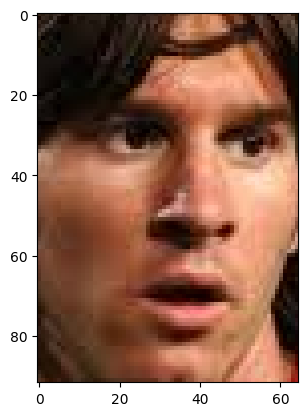

In [29]:
img_1 = Image.open('images_asset/messi_1.jpeg')
img_2 = Image.open('images_asset/messi_2.jpeg')
img_3 = Image.open('images_asset/messi_3.jpeg')

boxes, _ = mtcnn.detect(img_2)


# Draw bounding boxes and extract faces
fig, ax = plt.subplots()
ax.imshow(img_2)
for box in boxes:
    rect = plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], fill=False, color='red')
    ax.add_patch(rect)

    # Crop face
    face = img_2.crop(box)
    plt.imshow(face)
    plt.show()

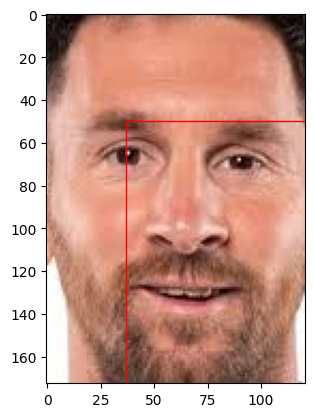

In [37]:
boxes3, _ = mtcnn.detect(img_3)


# Draw bounding boxes and extract faces
fig, ax = plt.subplots()
ax.imshow(img_3)
for box in boxes3:
    rect = plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], fill=False, color='red')
    ax.add_patch(rect)

    # Crop face
    face_3 = img_3.crop(box)
    plt.imshow(face_3)
    plt.show()

In [30]:
from PIL import Image
import torch

transform = transforms.Compose([
    transforms.ToTensor(),  
])
""" 
Check print for debugging
Check for version
Check for mtcnn function
"""
# Load your image and convert it

boxes, _ = mtcnn.detect(img_1)
if boxes is not None:
    #Extract face embeddings
    aligned_faces = mtcnn(img_1)
    if aligned_faces is not None:
        aligned_faces = aligned_faces.to(device)
        with torch.no_grad():
            embedding_2 = model_face(aligned_faces[0].unsqueeze(0)).squeeze(0)

#     else:
#         print("Face alignment failed.")
# else:
#     print("No faces detected.")

In [31]:
boxes1, _ = mtcnn.detect(img_3)
if boxes1 is not None:
    #Extract face embeddings
    aligned_faces_1 = mtcnn(img_3)
    if aligned_faces_1 is not None:
        aligned_faces_1 = aligned_faces_1.to(device)
        with torch.no_grad():
            embedding_1 = model_face(aligned_faces_1[0].unsqueeze(0)).squeeze(0)

        

In [32]:
similarity_score = cosine_similarity(embedding_1, embedding_2)
print(f"Cosine Similarity: {similarity_score:.3f}")

Cosine Similarity: 0.928


In [31]:
img_2_tensor = transform(img_2).to(device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


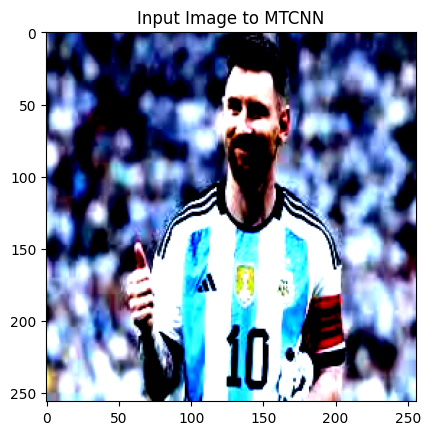

In [37]:
import matplotlib.pyplot as plt
tensor_on_cpu = img_1_tensor.cpu()

plt.imshow(tensor_on_cpu.permute(1, 2, 0))
plt.title("Input Image to MTCNN")
plt.show()

In [34]:
# Detect faces
boxes, probs = mtcnn.detect(img_2_tensor)
print("Boxes:", boxes)
print("Probabilities:", probs)

# # Check if any faces were detected
# if boxes is not None:
#     # Extract face embeddings
#     aligned_faces = mtcnn(img_1_tensor)
#     if aligned_faces is not None:
#         aligned_faces = aligned_faces.to(device)
#         embeddings = model_face(aligned_faces).detach()
#     else:
#         print("Face alignment failed.")
# else:
#     print("No faces detected.")


RuntimeError: torch.cat(): expected a non-empty list of Tensors

In [19]:
# Check the size and type of the input tensor
print("Tensor shape:", img_1_tensor.shape)
print("Tensor type:", img_1_tensor.dtype)

Tensor shape: torch.Size([3, 180, 280])
Tensor type: torch.float32


In [ ]:
img_1 = Image.open('images_asset\messi_1.jpeg')
img_2 = Image.open('images_asset\messi_2.jpeg')
# Detect faces in the image
boxes1, _ = mtcnn.detect(img_1)

# If faces are detected, extract embeddings
if boxes1 is not None:
    aligned_1 = mtcnn(img_1)
    embeddings_1 = model_face(aligned_1).detach()

boxes_2, _ = mtcnn.detect(img_2)

# If faces are detected, extract embeddings
if boxes_2 is not None:
    aligned_2 = mtcnn(img_2)
    embeddings_2 = resnet(aligned_2).detach()

In [ ]:
# Detect faces in the image

from scipy.spatial.distance import cosine

# Calculate cosine similarity between ResNet features
similarity_resnet = 1 - cosine(embeddings.flatten(), embeddings_2.flatten())

print(f"Cosine similarity using ResNet: {similarity_resnet}")

In [ ]:
from torch.utils.data import DataLoader

# Assuming TripletDataset is a class that prepares your dataset in the form of (anchor, positive, negative)
class TripletDataset(Dataset):
    def __init__(self, data, transform=None):
        # data would be a list of tuples (anchor, positive, negative)
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        anchor, positive, negative = self.data[idx]
        
        if self.transform:
            anchor = self.transform(anchor)
            positive = self.transform(positive)
            negative = self.transform(negative)
        
        return anchor, positive, negative

# Load your datasets
train_data = TripletDataset(train_dataset, transform=train_transform)  # train_dataset and train_transform should be defined
val_data = TripletDataset(val_dataset, transform=val_transform)  # val_dataset and val_transform should be defined

# Create the data loaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

# Now you can pass these loaders to the train and evaluate functions
train(model, train_loader, loss_func, optimizer, num_epochs, device)
evaluate(model, val_loader, loss_func, device)
